In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision.transforms import Grayscale
from einops import rearrange

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.Size([300, 300, 3])

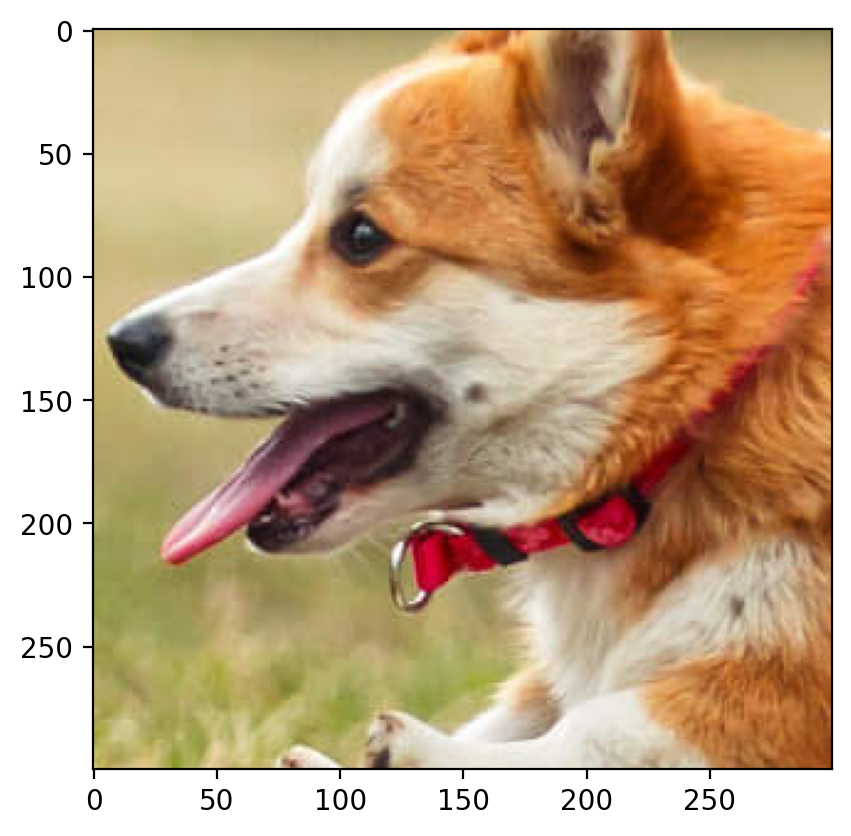

In [2]:
original_image = torchvision.io.read_image('dog.jpg')
cropped_image = torchvision.transforms.functional.crop(original_image,600,800,300,300)
cropped_image = rearrange(cropped_image,'c h w -> h w c')
plt.imshow(cropped_image)
cropped_image.shape

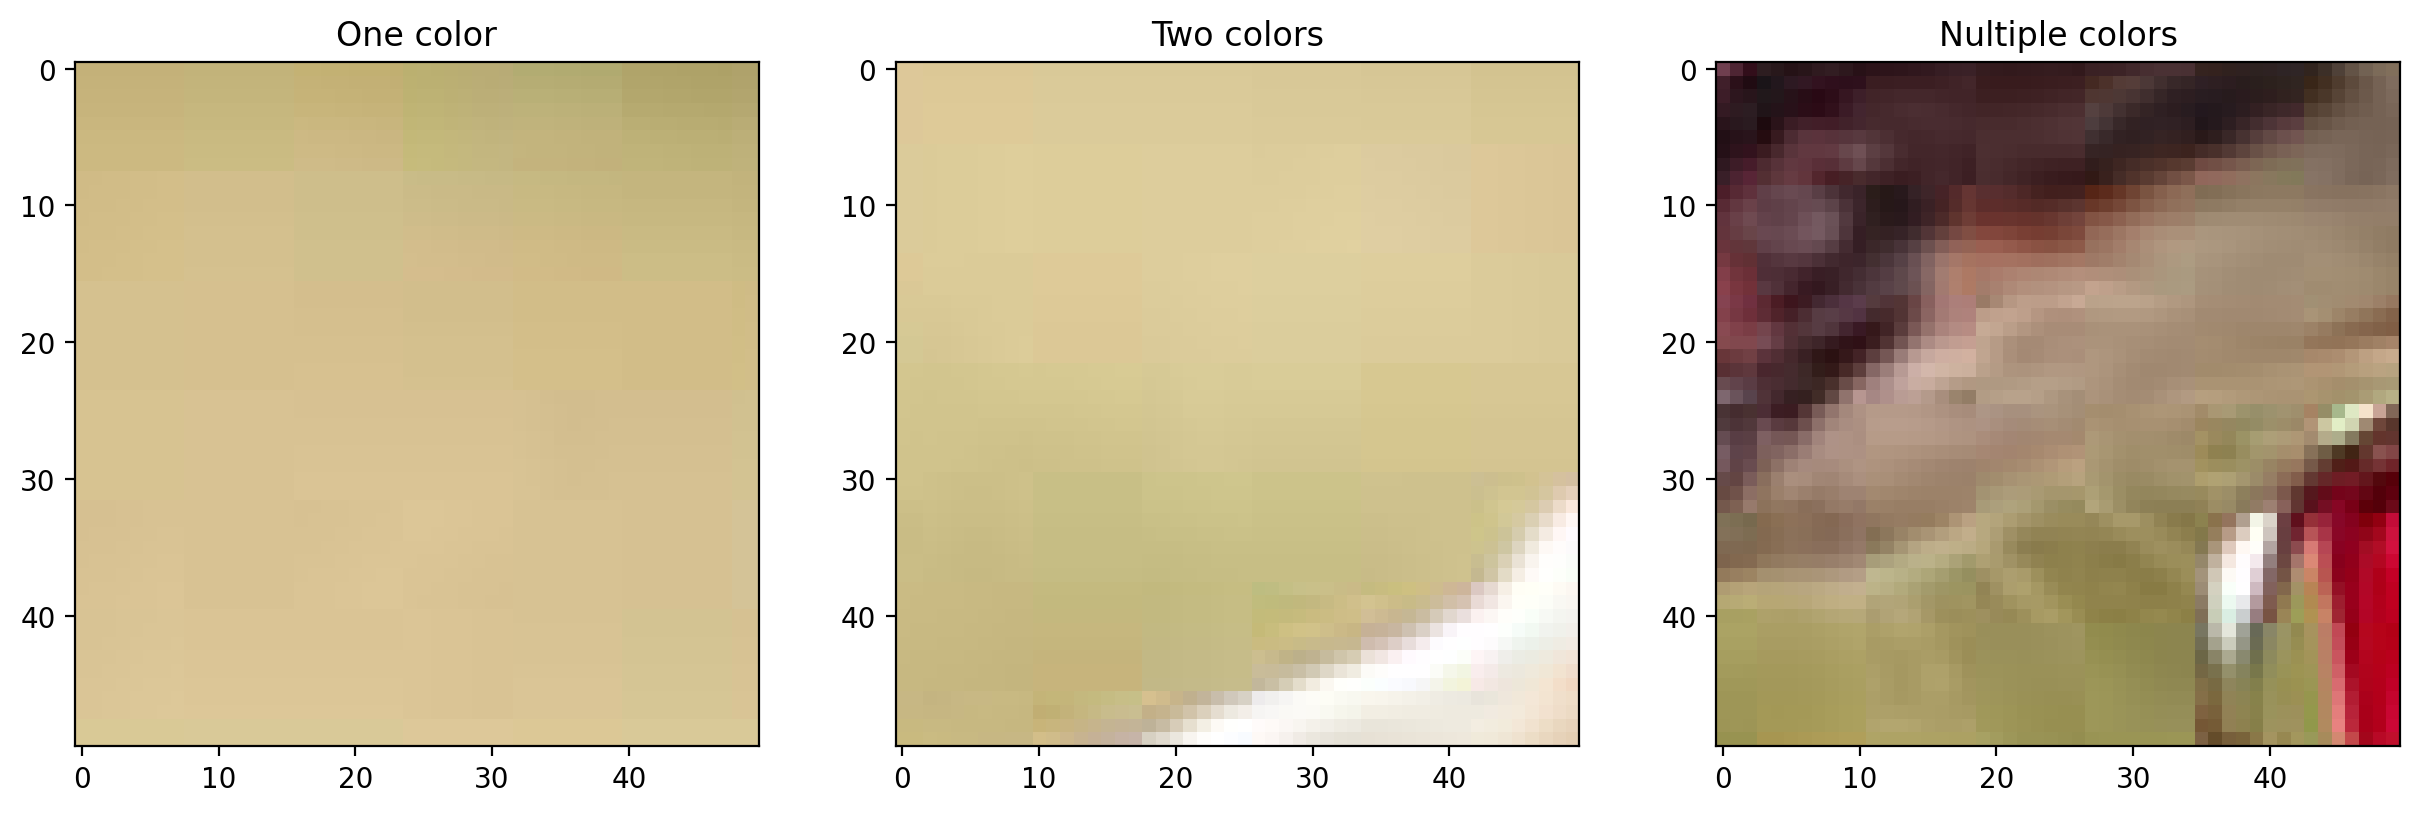

In [3]:
patch_1 = cropped_image[:50, :50]
patch_2 = cropped_image[50:100,30:80]
patch_3 = cropped_image[175:225,85:135]
ax, fig = plt.subplots(1,3, figsize=(15,15))
fig[0].imshow(patch_1)
fig[0].set_title('One color') 
fig[1].imshow(patch_2)
fig[1].set_title('Two colors')
fig[2].imshow(patch_3)
fig[2].set_title('Nultiple colors')
plt.show()


In [4]:
def rmse(image1, image2):
    return np.sqrt(np.mean((image1 - image2) ** 2))
def peak_snr(image1, image2):
    return 20 * np.log10(255 / rmse(image1, image2))

In [5]:
def factorize(A: torch.Tensor, k: int, epochs: int):
    '''
    Function to factorize an RGB image matrix A into two matrices W and H.
    The matrix A is of shape (m, n, 3) and the matrices W and H are of shape (m, k, 3) and (k, n, 3) respectively.

    Input:
    A: torch.Tensor: The matrix to be factorized (shape: m, n, 3)
    k: int: The rank of the factorization
    epochs: int: The number of epochs to train the model

    Returns:
    W: torch.Tensor: The matrix W of shape (m, k, 3)
    H: torch.Tensor: The matrix H of shape (k, n, 3)
    '''    
    m, n, c = A.shape  # Get dimensions of the input tensor
    W = torch.rand((m, k, c), requires_grad=True, device=device)
    H = torch.rand((k, n, c), requires_grad=True, device=device)
    A = A.to(device)
    
    optimizer = optim.Adam([W, H], lr=0.01)
    loss_arr = []
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        
        # Compute A_hat for each channel separately
        A_hat = torch.zeros_like(A, device=device)
        for channel in range(c):
            A_hat[:, :, channel] = torch.matmul(W[:, :, channel], H[:, :, channel])
        
        loss = F.mse_loss(A_hat, A)
        loss.backward()
        optimizer.step()
        loss_arr.append(loss.item())
        
        if epoch % 100 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')
    
    return W, H, loss_arr


In [6]:
factorized_params = factorize(patch_1.float(), 50, 1000)

Epoch 1/1000, Loss: 29086.76171875
Epoch 101/1000, Loss: 4278.267578125
Epoch 201/1000, Loss: 9.145401000976562
Epoch 301/1000, Loss: 5.256322860717773
Epoch 401/1000, Loss: 5.216467380523682
Epoch 501/1000, Loss: 5.179279327392578
Epoch 601/1000, Loss: 5.136539459228516
Epoch 701/1000, Loss: 5.087786674499512
Epoch 801/1000, Loss: 5.032223224639893
Epoch 901/1000, Loss: 4.968677043914795


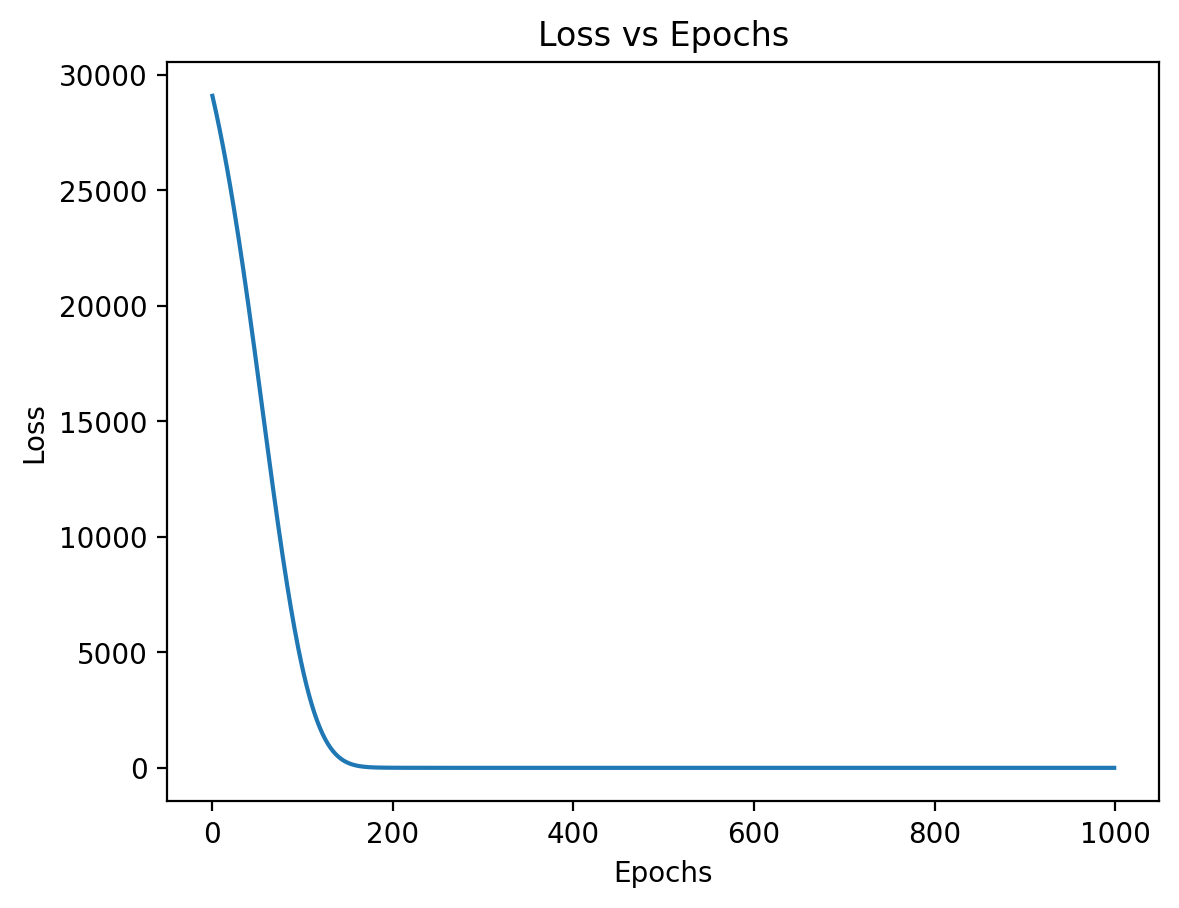

In [7]:
x = np.arange(len(factorized_params[2]))
plt.plot(x, factorized_params[2])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.show()

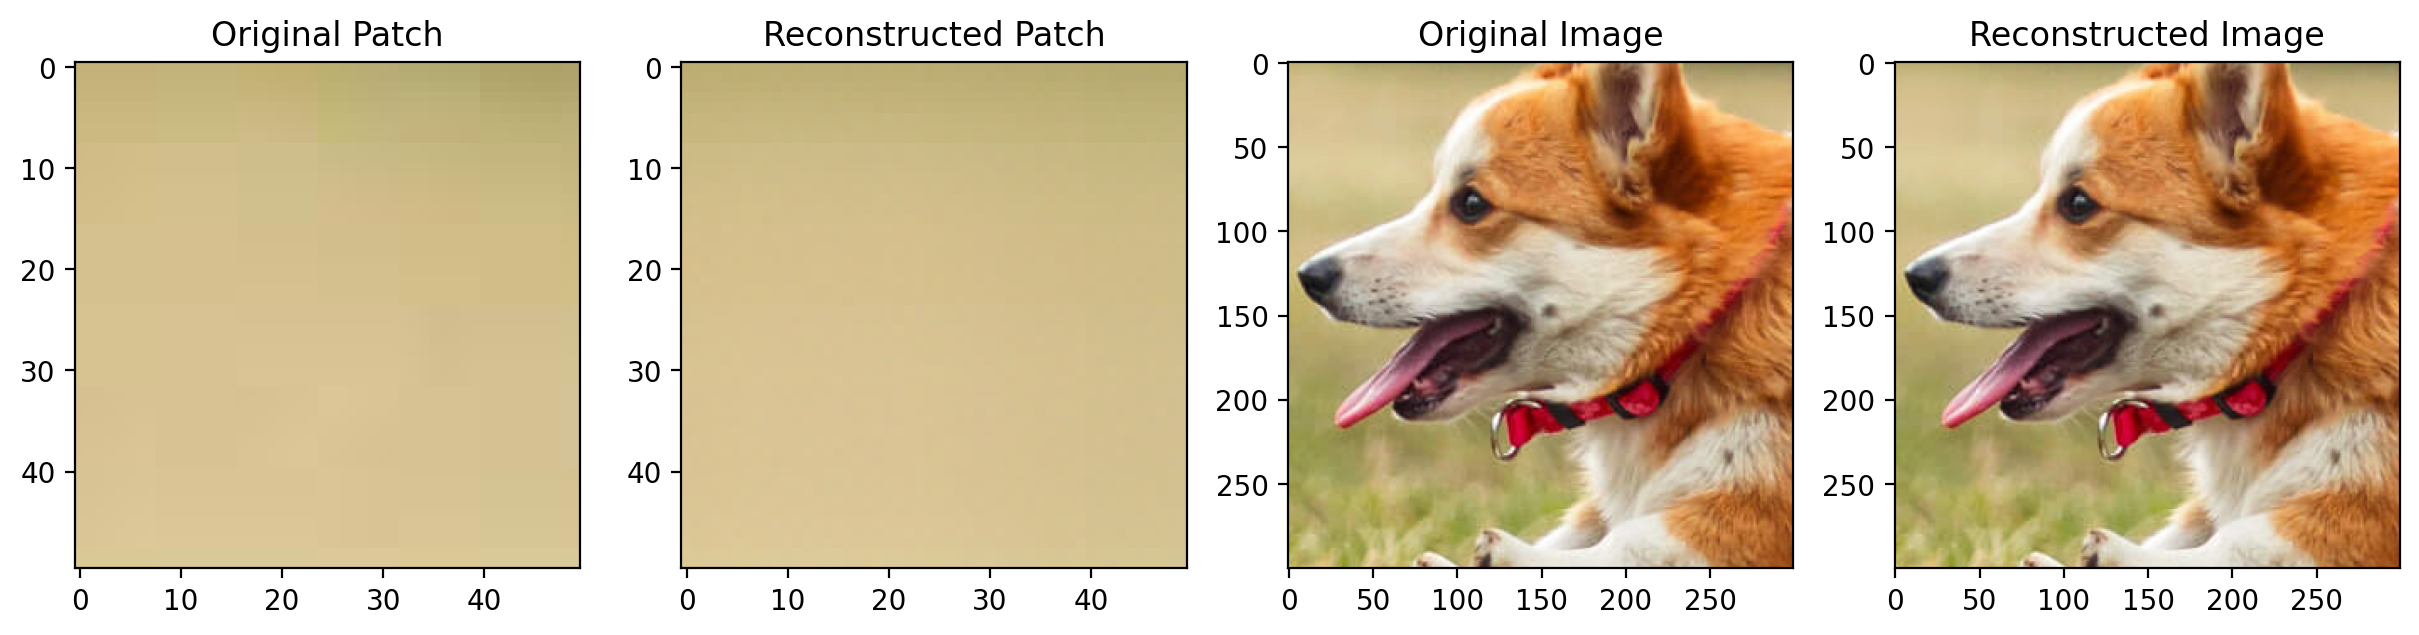

In [8]:
channel_1 = torch.matmul(factorized_params[0][:, :, 0], factorized_params[1][:, :, 0])
channel_2 = torch.matmul(factorized_params[0][:, :, 1], factorized_params[1][:, :, 1])
channel_3 = torch.matmul(factorized_params[0][:, :, 2], factorized_params[1][:, :, 2])
reconstructed_image = torch.stack([channel_1, channel_2, channel_3])
reconstructed_image = torch.clamp(reconstructed_image, 0, 255)
copy = cropped_image.detach().clone().cpu().numpy()
copy[:50, :50] = reconstructed_image.permute(1, 2, 0).cpu().detach().numpy().astype(np.uint8)
fig,ax = plt.subplots(1,4, figsize=(15,15))
ax[0].imshow(patch_1)
ax[0].set_title('Original Patch')
ax[1].imshow(reconstructed_image.permute(1, 2, 0).cpu().detach().numpy().astype(np.uint8))
ax[1].set_title('Reconstructed Patch')
ax[2].imshow(cropped_image)
ax[2].set_title('Original Image')
ax[3].imshow(copy)
ax[3].set_title('Reconstructed Image')
plt.show()

In [9]:
print(f'RMSE: {rmse(cropped_image.detach().cpu().numpy(), copy)}')
print(f'Peak Signal-to-Noise Ratio: {peak_snr(cropped_image.detach().cpu().numpy(), copy)}')

RMSE: 0.380929662020966
Peak Signal-to-Noise Ratio: 56.51390778105912


Epoch 1/10000, Loss: 32666.21875
Epoch 101/10000, Loss: 5604.50048828125
Epoch 201/10000, Loss: 248.4677276611328
Epoch 301/10000, Loss: 238.00436401367188
Epoch 401/10000, Loss: 236.3710479736328
Epoch 501/10000, Loss: 233.7271270751953
Epoch 601/10000, Loss: 228.7472381591797
Epoch 701/10000, Loss: 218.54150390625
Epoch 801/10000, Loss: 197.7725067138672
Epoch 901/10000, Loss: 163.0981903076172
Epoch 1001/10000, Loss: 127.07720947265625
Epoch 1101/10000, Loss: 104.64950561523438
Epoch 1201/10000, Loss: 91.34488677978516
Epoch 1301/10000, Loss: 80.08429718017578
Epoch 1401/10000, Loss: 67.95938110351562
Epoch 1501/10000, Loss: 55.50768280029297
Epoch 1601/10000, Loss: 44.16474533081055
Epoch 1701/10000, Loss: 34.67171859741211
Epoch 1801/10000, Loss: 27.20366096496582
Epoch 1901/10000, Loss: 21.708999633789062
Epoch 2001/10000, Loss: 17.764949798583984
Epoch 2101/10000, Loss: 14.766458511352539
Epoch 2201/10000, Loss: 12.296452522277832
Epoch 2301/10000, Loss: 10.189390182495117
Epoch

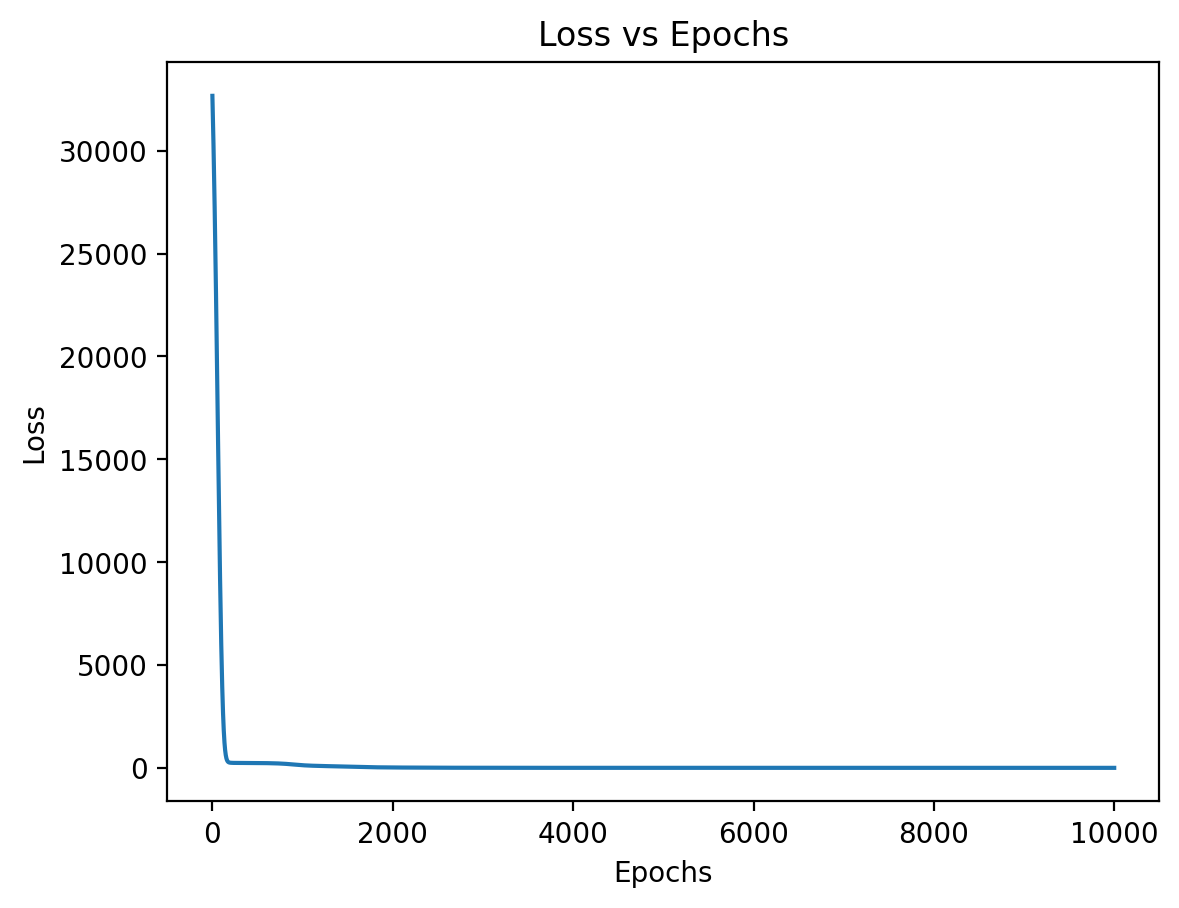

In [13]:
factorized_params_two_color = factorize(patch_2.float(), 50, 10000)
x = np.arange(len(factorized_params_two_color[2]))
plt.plot(x, factorized_params_two_color[2])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.show()

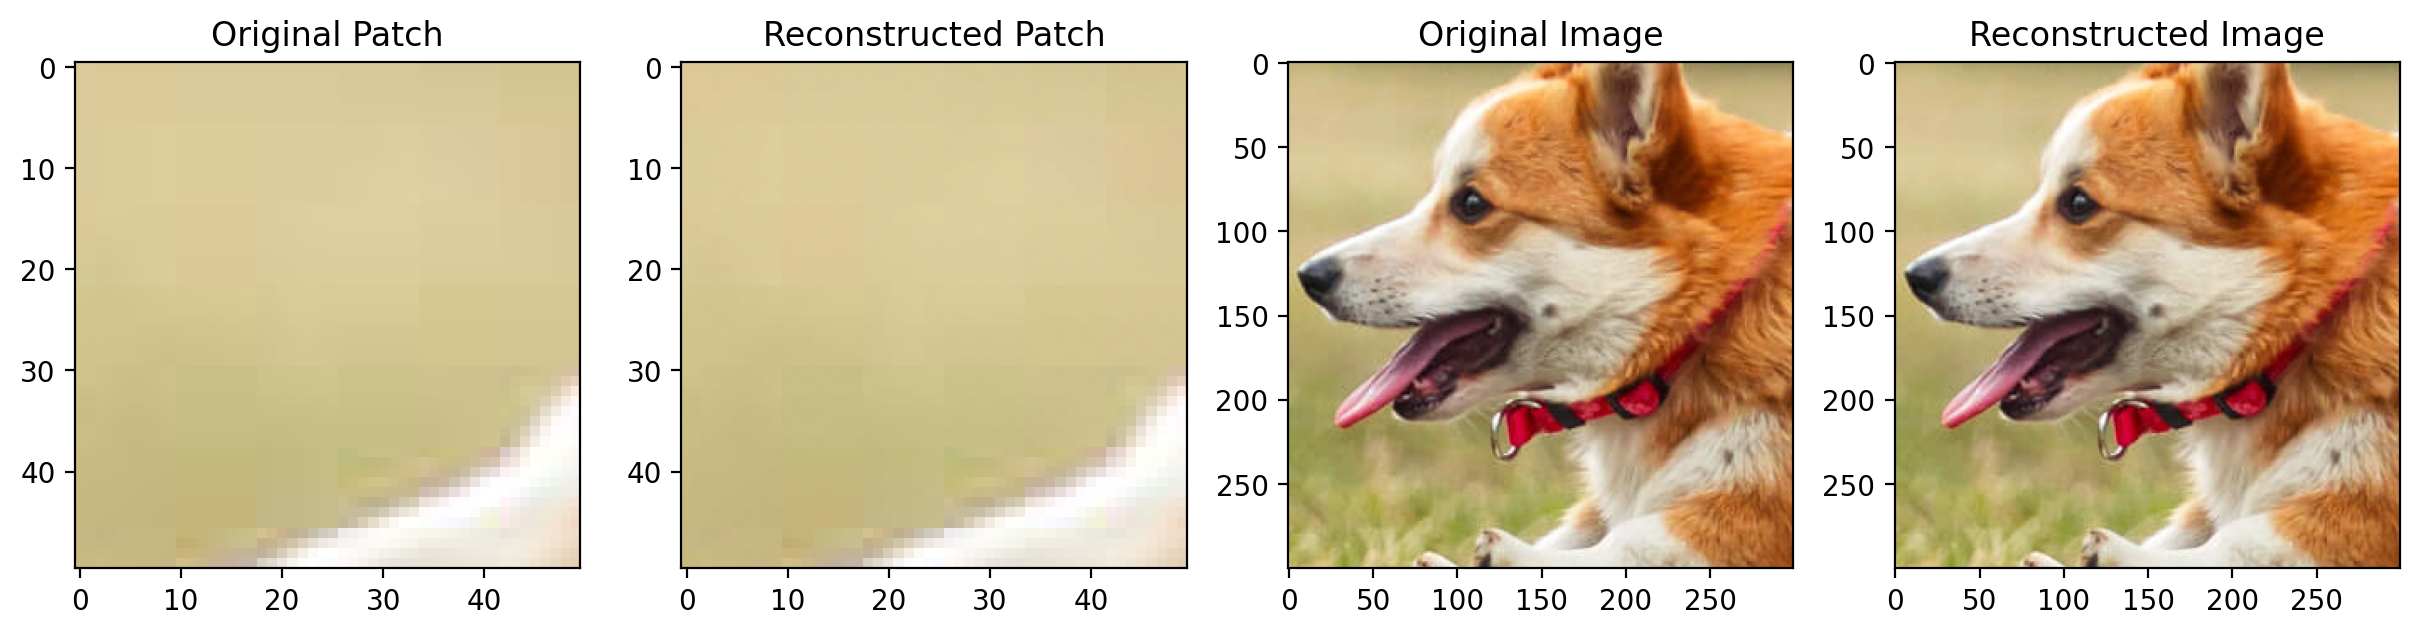

In [14]:
channel_1 = torch.matmul(factorized_params_two_color[0][:, :, 0], factorized_params_two_color[1][:, :, 0])
channel_2 = torch.matmul(factorized_params_two_color[0][:, :, 1], factorized_params_two_color[1][:, :, 1])
channel_3 = torch.matmul(factorized_params_two_color[0][:, :, 2], factorized_params_two_color[1][:, :, 2])
reconstructed_image = torch.stack([channel_1, channel_2, channel_3])
reconstructed_image = torch.clamp(reconstructed_image, 0, 255)
copy = cropped_image.detach().clone().cpu().numpy()
copy[50:100,30:80] = reconstructed_image.permute(1, 2, 0).cpu().detach().numpy().astype(np.uint8)
fig,ax = plt.subplots(1,4, figsize=(15,15))
ax[0].imshow(patch_2)
ax[0].set_title('Original Patch')
ax[1].imshow(reconstructed_image.permute(1, 2, 0).cpu().detach().numpy().astype(np.uint8))
ax[1].set_title('Reconstructed Patch')
ax[2].imshow(cropped_image)
ax[2].set_title('Original Image')
ax[3].imshow(copy)
ax[3].set_title('Reconstructed Image')
plt.show()

In [15]:
print(f'RMSE: {rmse(cropped_image.detach().cpu().numpy(), copy)}')
print(f'Peak Signal-to-Noise Ratio: {peak_snr(cropped_image.detach().cpu().numpy(), copy)}')

RMSE: 0.11745763617703318
Peak Signal-to-Noise Ratio: 66.73317847942586


Epoch 1/2000, Loss: 13695.6416015625
Epoch 101/2000, Loss: 7252.33935546875
Epoch 201/2000, Loss: 1668.1181640625
Epoch 301/2000, Loss: 907.0203857421875
Epoch 401/2000, Loss: 877.1466674804688
Epoch 501/2000, Loss: 863.5830688476562
Epoch 601/2000, Loss: 822.3043823242188
Epoch 701/2000, Loss: 733.7131958007812
Epoch 801/2000, Loss: 629.9111938476562
Epoch 901/2000, Loss: 555.5460205078125
Epoch 1001/2000, Loss: 508.3267517089844
Epoch 1101/2000, Loss: 460.3749084472656
Epoch 1201/2000, Loss: 402.189453125
Epoch 1301/2000, Loss: 339.49786376953125
Epoch 1401/2000, Loss: 275.3169860839844
Epoch 1501/2000, Loss: 217.00283813476562
Epoch 1601/2000, Loss: 175.09169006347656
Epoch 1701/2000, Loss: 147.1254119873047
Epoch 1801/2000, Loss: 125.51424407958984
Epoch 1901/2000, Loss: 107.27690124511719


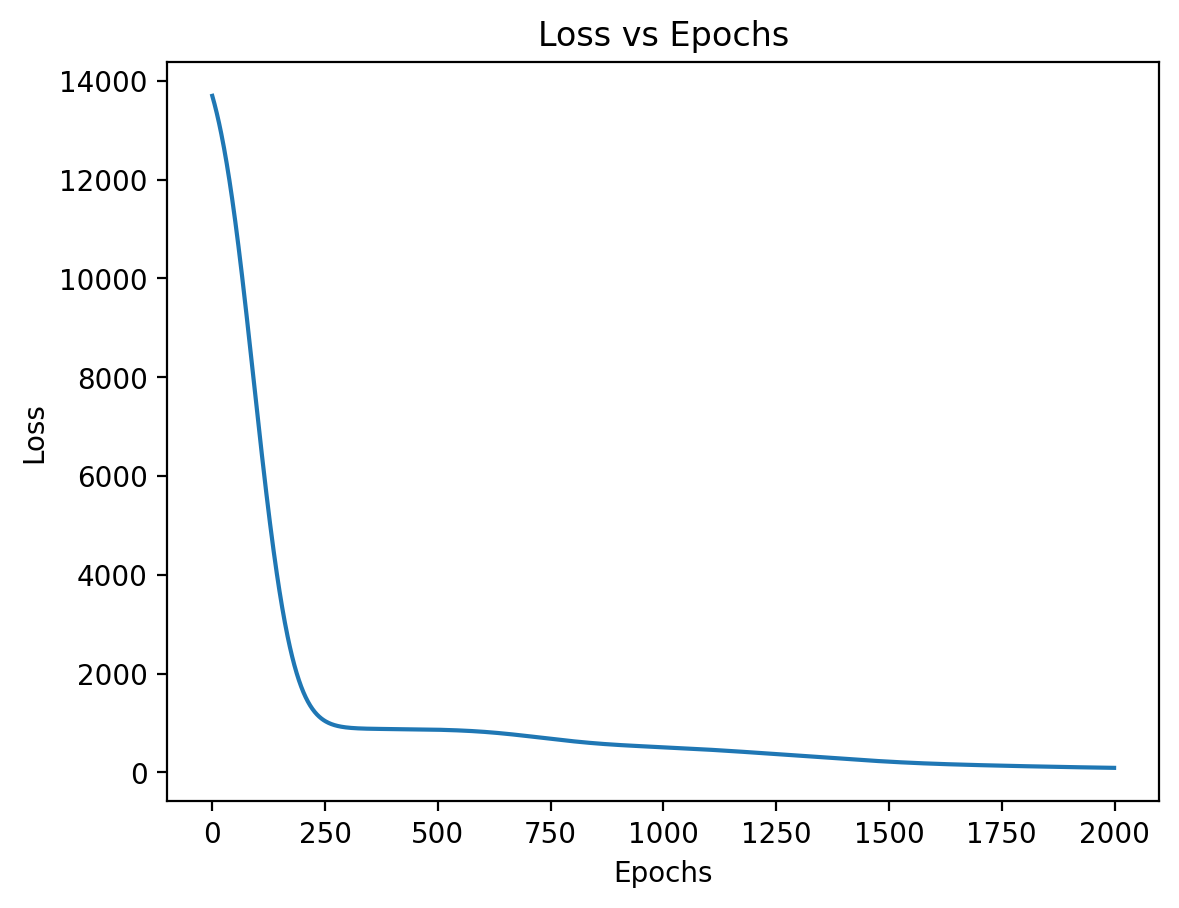

In [41]:
factorized_params_multi_color = factorize(patch_3.float(), 15, 2000)
x = np.arange(len(factorized_params_multi_color[2]))
plt.plot(x, factorized_params_multi_color[2])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.show()

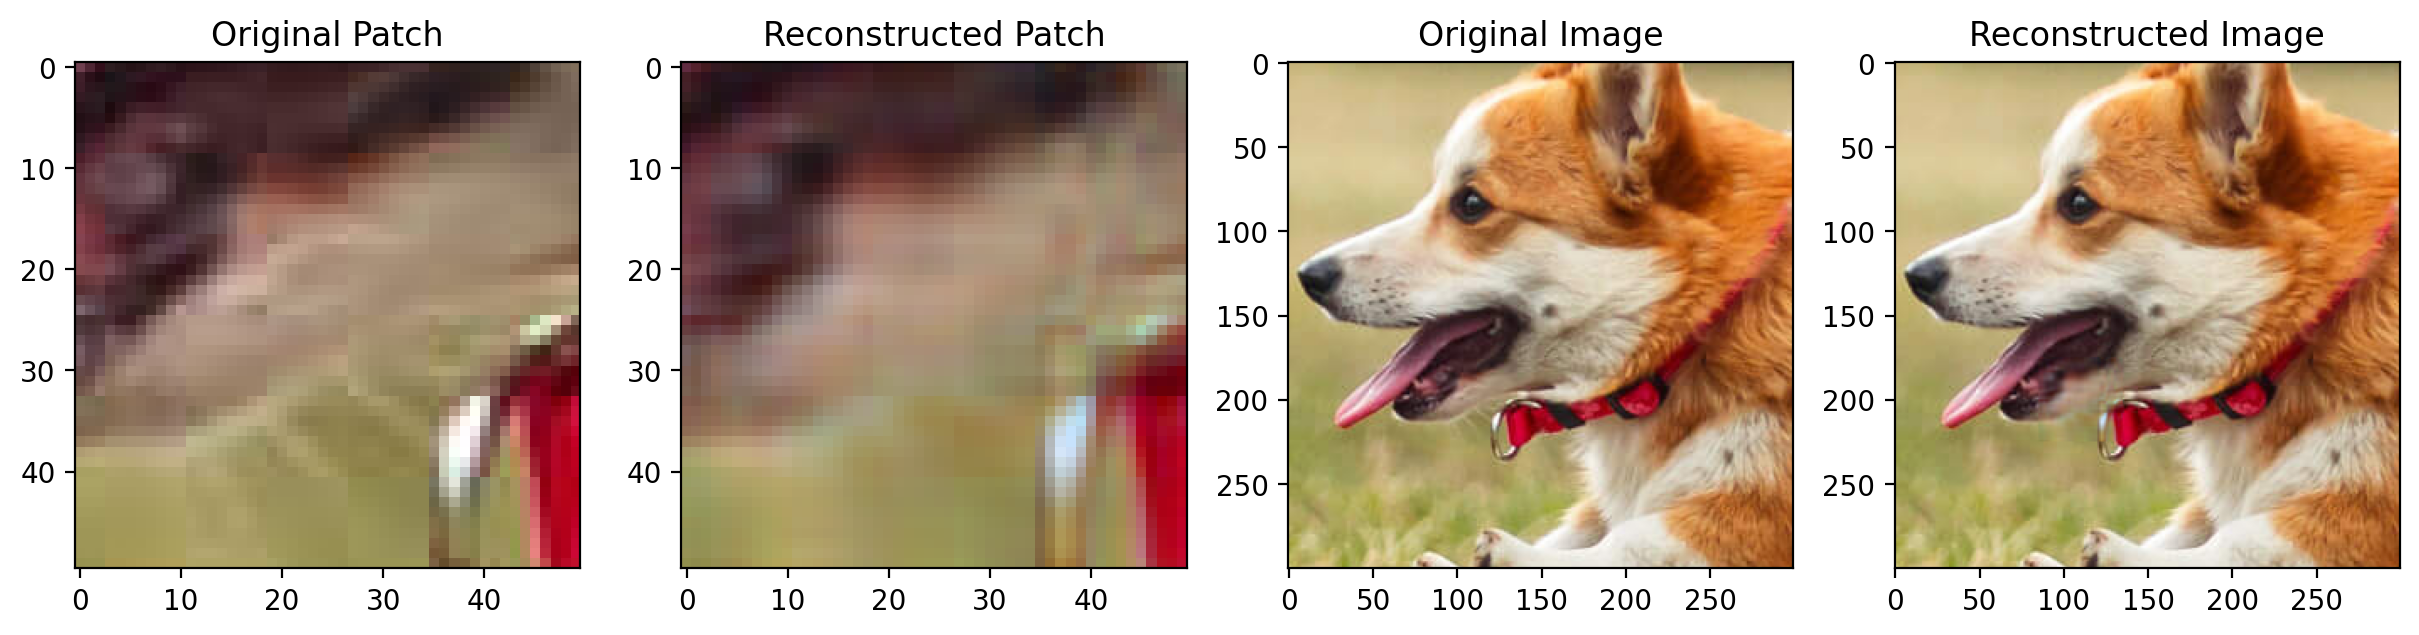

In [42]:
channel_1 = torch.matmul(factorized_params_multi_color[0][:, :, 0], factorized_params_multi_color[1][:, :, 0])
channel_2 = torch.matmul(factorized_params_multi_color[0][:, :, 1], factorized_params_multi_color[1][:, :, 1])
channel_3 = torch.matmul(factorized_params_multi_color[0][:, :, 2], factorized_params_multi_color[1][:, :, 2])
reconstructed_image = torch.stack([channel_1, channel_2, channel_3])
reconstructed_image = torch.clamp(reconstructed_image, 0, 255)
copy = cropped_image.detach().clone().cpu().numpy()
copy[175:225,85:135] = reconstructed_image.permute(1, 2, 0).cpu().detach().numpy().astype(np.uint8)
fig,ax = plt.subplots(1,4, figsize=(15,15))
ax[0].imshow(patch_3)
ax[0].set_title('Original Patch')
ax[1].imshow(reconstructed_image.permute(1, 2, 0).cpu().detach().numpy().astype(np.uint8))
ax[1].set_title('Reconstructed Patch')
ax[2].imshow(cropped_image)
ax[2].set_title('Original Image')
ax[3].imshow(copy)
ax[3].set_title('Reconstructed Image')
plt.show()